In [1]:
import calendar
import json
import math
import numpy
import os
import pandas
import pyarrow
import sys

from datetime import date, datetime
from os import path
from dotenv import load_dotenv
from sqlalchemy import create_engine

# Steps to install
# 1. pip install sqlalchemy-bigquery google-cloud-bigquery-storage pyarrow
# 2. Copy the credentials file to wherever you set BIGQUERY_CREDENTIALS_PATH to

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

In [2]:
sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
import create_queries
%load_ext autoreload
%autoreload 2

In [3]:
COMPANY_IDENTIFIER = 'SO'
COMPANY_NAME = COMPANY_IDENTIFIER
TRANSFER_PACKAGES_START_DATE = '2020-01-01'
SALES_TRANSACTIONS_START_DATE = '2020-01-01'
ANALYSIS_PARAMS = {
    'sold_threshold': 1.0,
    'find_parent_child_relationships': False,
    'use_prices_to_fill_missing_incoming': False,
    'external_pricing_data_config': {
        'category_to_fixed_prices': {
           "Capsule (weight - each)":{
              "Each":23.594097452934655
           },
           "Clone - Cutting":{
              "Each":2.153121902874133
           },
           "Clone - Tissue Culture":{
              "Each": 4.0
           },
           "Edible (volume - each)":{
              "Each":6.146205207527713
           },
           "Edible (weight - each)":{
              "Each":7.5740532898741435
           },
           "Extract (volume - each)":{
              "Each":11.43294776119403
           },
           "Extract (weight - each)":{
              "Each":9.832834338863785
           },
           "Extract (weight)":{
              "Grams":23.60053333333333,
              "Pounds":10705.013115733333
           },
           "Flower":{
              "Grams":0.6615655299919327,
              "Pounds": 0.2
           },
           "Flower (packaged - each)":{
              "Each":6.62190019193858
           },
           "Flower (packaged eighth - each)":{
              "Each":7.620680869582421
           },
           "Flower (packaged gram - each)":{
              "Each":0.36474099339160093
           },
           "Flower (packaged half ounce - each)":{
              "Each":17.340007024938533
           },
           "Flower (packaged ounce - each)":{
              "Each":72.03456896551724
           },
           "Flower (packaged quarter - each)":{
              "Each":14.970933920704848
           },
           "Fresh Cannabis Plant":{
              "Pounds": 4.0
           },
           "Immature Plant":{
              "Each":0.6451699946033459
           },
           "Leaf":{
              "Grams": 4.0,
              "Pounds": 4.0
           },
           "Other Concentrate (volume - each)":{
              "Each":10.0
           },
           "Other Concentrate (weight - each)":{
              "Each": 9.10354624425141
           },
           "Other Concentrate (weight)":{
              "Grams": 4.0
           },
           "Pre-Roll Flower":{
              "Each":1.2455980167454037
           },
           "Pre-Roll Infused":{
              "Each":3.4070715249662618
           },
           "Pre-Roll Leaf":{
              "Each":0.2721679544530297
           },
           "Seeds":{
              "Grams":4.0,
              "Ounces":4.0,
              "Pounds":4.0
           },
           "Seeds (each)":{
              "Each":13.81578947368421
           },
           "Shake":{
              "Pounds": 4.0
           },
           "Shake (Packaged Half Ounce - each)":{
              "Each":13.5
           },
           "Shake (Packaged Quarter - each)":{
              "Each":0.01
           },
           "Tincture (volume - each)":{
              "Each":18.740093427835063
           },
           "Topical (volume - each)":{
              "Each":15.084248927038628
           },
           "Topical (weight - each)":{
              "Each":6.851502702702704
           },
           "Vape Cartridge (volume - each)":{
              "Each":19.749874823014572
           },
           "Vape Cartridge (weight - each)":{
              "Each":16.83838680865686
           }
        }
    }
}

In [4]:
# Note: we query sales receipts and sales transactions 1st, because we use sales data
# to determine which licenses we want to pull other data for (only retailer licenses).
company_sales_receipts_query = create_queries.create_company_sales_receipts_query(COMPANY_IDENTIFIER, SALES_TRANSACTIONS_START_DATE)
company_sales_transactions_query = create_queries.create_company_sales_transactions_query(COMPANY_IDENTIFIER, SALES_TRANSACTIONS_START_DATE)

company_sales_receipts_dataframe = pandas.read_sql_query(company_sales_receipts_query, engine)
company_sales_transactions_dataframe = pandas.read_sql_query(company_sales_transactions_query, engine)

In [5]:
unique_sales_receipt_license_numbers = company_sales_receipts_dataframe['license_number'].unique()
unique_sales_receipt_license_numbers = list(unique_sales_receipt_license_numbers)
unique_sales_receipt_license_numbers

['C9-0000130-LIC', 'C10-0000271-LIC']

In [6]:
# Download packages, sales transactions, incoming / outgoing tranfers
company_incoming_transfer_packages_query = create_queries.create_company_incoming_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=unique_sales_receipt_license_numbers,
)
company_outgoing_transfer_packages_query = create_queries.create_company_outgoing_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=unique_sales_receipt_license_numbers,
)
company_inventory_packages_query = create_queries.create_company_inventory_packages_query(
    COMPANY_IDENTIFIER,
    license_numbers=unique_sales_receipt_license_numbers,
    include_quantity_zero=True,
)

company_incoming_transfer_packages_dataframe = pandas.read_sql_query(company_incoming_transfer_packages_query, engine)
company_outgoing_transfer_packages_dataframe = pandas.read_sql_query(company_outgoing_transfer_packages_query, engine)
company_inventory_packages_dataframe = pandas.read_sql_query(company_inventory_packages_query, engine)

In [7]:
TODAY_DATE = date.today().strftime('%Y-%m-%d')
print(f'Today is {TODAY_DATE}')

Today is 2021-11-11


In [8]:
company_incoming_transfer_packages_dataframe['created_month'] = pandas.to_datetime(company_incoming_transfer_packages_dataframe['created_date']).dt.strftime('%Y-%m')
unique_incoming_transfer_package_months = company_incoming_transfer_packages_dataframe['created_month'].unique()

In [9]:
company_sales_receipts_dataframe['sales_month'] = pandas.to_datetime(company_sales_receipts_dataframe['sales_datetime']).dt.strftime('%Y-%m')
unique_company_sales_receipt_months = company_sales_receipts_dataframe['sales_month'].unique()

In [10]:
aggregate_unique_months = []
for month in unique_incoming_transfer_package_months:
    if month not in aggregate_unique_months:
        aggregate_unique_months.append(month)
for month in unique_company_sales_receipt_months:
    if month not in aggregate_unique_months:
        aggregate_unique_months.append(month)
aggregate_unique_months.sort()

unique_inventory_dates = []
for month in aggregate_unique_months:
    date_object = datetime.strptime(month, '%Y-%m')
    date_object = date_object.replace(day = calendar.monthrange(date_object.year, date_object.month)[1])
    eom_date_str = datetime.strftime(date_object, '%Y-%m-%d')
    if eom_date_str < TODAY_DATE:
        unique_inventory_dates.append(eom_date_str)

unique_inventory_dates.append(TODAY_DATE)
unique_inventory_dates = [datetime.strftime(datetime.strptime(unique_inventory_date, '%Y-%m-%d'), '%m/%d/%Y') for unique_inventory_date in unique_inventory_dates]

INVENTORY_DATES = unique_inventory_dates
print(INVENTORY_DATES)

['01/31/2020', '02/29/2020', '03/31/2020', '04/30/2020', '05/31/2020', '06/30/2020', '07/31/2020', '08/31/2020', '09/30/2020', '10/31/2020', '11/30/2020', '12/31/2020', '01/31/2021', '02/28/2021', '03/31/2021', '04/30/2021', '05/31/2021', '06/30/2021', '07/31/2021', '08/31/2021', '09/30/2021', '10/31/2021', '11/11/2021']


In [11]:
sys.path.append(path.realpath(path.join(os.getcwd(), "../../scripts/analysis")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))

from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util
from bespoke.inventory.analysis import inventory_cogs_util as cogs_util

def _reload_libs():
    import importlib
    importlib.reload(util)
    importlib.reload(valuations_util)
    importlib.reload(cogs_util)

In [12]:
sql_helper = util.BigQuerySQLHelper(engine)

d = util.Download()
d.download_dataframes(
    incoming_transfer_packages_dataframe=company_incoming_transfer_packages_dataframe,
    outgoing_transfer_packages_dataframe=company_outgoing_transfer_packages_dataframe,
    sales_receipts_dataframe=company_sales_receipts_dataframe,
    sales_transactions_dataframe=company_sales_transactions_dataframe,
    inventory_packages_dataframe=company_inventory_packages_dataframe,
    sql_helper=sql_helper,
)

In [13]:
q = util.Query()
q.inventory_dates = INVENTORY_DATES
q.company_name = COMPANY_NAME

id_to_history = util.get_histories(d, params=ANALYSIS_PARAMS)
util.print_counts(id_to_history)

Only outgoing: 10
Only incoming: 2022
Sold packages missing incoming_pkg: 425 (3.59% of packages)
Incoming packages missing price 1046 (9.17% of incoming packages)
In and out: 36
In and sold at least once 9371
In and sold many times 9098

 Num parent packages: 0
 num matched child packages: 0
Total pkgs: 11842


{'only_outgoing': 10,
 'only_incoming': 2022,
 'only_sold': 425,
 'outgoing_and_incoming': 36,
 'incoming_missing_prices': 1046,
 'in_and_sold_at_least_once': 9371,
 'in_and_sold_many_times': 9098,
 'num_parent_packages': 0,
 'num_child_packages': 0,
 'total_seen': 11842}

In [14]:
date_to_inventory_packages_dataframe = {}
inventory_valuations = []

for inventory_date in INVENTORY_DATES:
    computed_inventory_package_records = util.create_inventory_dataframe_by_date(
        id_to_history,
        inventory_date,
        params=ANALYSIS_PARAMS,
    )    
    computed_inventory_packages_dataframe = pandas.DataFrame(
        computed_inventory_package_records,
        columns=util.get_inventory_column_names(),
    )
    date_to_inventory_packages_dataframe[inventory_date] = computed_inventory_packages_dataframe
    inventory_valuations.append(valuations_util.get_total_valuation_for_date(
        computed_inventory_packages_dataframe=computed_inventory_packages_dataframe,
        company_incoming_transfer_packages_dataframe=company_incoming_transfer_packages_dataframe,
    ))

WARN: incoming package #18673898 does not have a price
WARN: incoming package #18641080 does not have a price
WARN: incoming package #18641074 does not have a price
WARN: incoming package #18641077 does not have a price
WARN: incoming package #18641082 does not have a price
WARN: incoming package #18641083 does not have a price
WARN: incoming package #18641078 does not have a price
WARN: incoming package #18641076 does not have a price
WARN: incoming package #18641081 does not have a price
WARN: incoming package #18641075 does not have a price
WARN: incoming package #18641079 does not have a price
WARN: incoming package #18641073 does not have a price
WARN: incoming package #18573022 does not have a price
WARN: incoming package #18573023 does not have a price
WARN: incoming package #18420023 does not have a price
WARN: incoming package #18425063 does not have a price
WARN: incoming package #18355856 does not have a price
WARN: incoming package #18356310 does not have a price
WARN: inco

WARN: incoming package #13983522 does not have a price
WARN: incoming package #14307127 does not have a price
WARN: incoming package #14228994 does not have a price
WARN: incoming package #14235353 does not have a price
WARN: incoming package #14137962 does not have a price
WARN: incoming package #14049612 does not have a price
WARN: incoming package #14136864 does not have a price
WARN: incoming package #14136863 does not have a price
WARN: incoming package #14096675 does not have a price
WARN: incoming package #14108360 does not have a price
WARN: incoming package #14029261 does not have a price
WARN: incoming package #13964353 does not have a price
WARN: incoming package #13911021 does not have a price
WARN: incoming package #13930688 does not have a price
WARN: incoming package #13929092 does not have a price
WARN: incoming package #13926713 does not have a price
WARN: incoming package #13932116 does not have a price
WARN: incoming package #13928717 does not have a price
WARN: inco

WARN: incoming package #10484629 does not have a price
WARN: incoming package #10470383 does not have a price
WARN: incoming package #10470382 does not have a price
WARN: incoming package #10299874 does not have a price
WARN: incoming package #10298174 does not have a price
WARN: incoming package #10316899 does not have a price
WARN: incoming package #10314207 does not have a price
WARN: incoming package #10006468 does not have a price
WARN: incoming package #10277282 does not have a price
WARN: incoming package #10036880 does not have a price
WARN: incoming package #10211499 does not have a price
WARN: incoming package #10205961 does not have a price
WARN: incoming package #9937956 does not have a price
WARN: incoming package #10006467 does not have a price
WARN: incoming package #10004580 does not have a price
WARN: incoming package #10005413 does not have a price
WARN: incoming package #10005414 does not have a price
WARN: incoming package #10005415 does not have a price
WARN: incom

WARN: incoming package #7584084 does not have a price
WARN: incoming package #5316285 does not have a price
WARN: incoming package #7569323 does not have a price
WARN: incoming package #7549598 does not have a price
WARN: incoming package #7541892 does not have a price
WARN: incoming package #7543006 does not have a price
WARN: incoming package #7474818 does not have a price
WARN: incoming package #7474703 does not have a price
WARN: incoming package #7474958 does not have a price
WARN: incoming package #6767380 does not have a price
WARN: incoming package #6767379 does not have a price
WARN: incoming package #6772681 does not have a price
WARN: incoming package #6756423 does not have a price
WARN: incoming package #6734713 does not have a price
WARN: incoming package #6734715 does not have a price
WARN: incoming package #6734714 does not have a price
WARN: incoming package #6756420 does not have a price
WARN: incoming package #6756421 does not have a price
WARN: incoming package #6756

WARN: incoming package #4712454 does not have a price
WARN: incoming package #4592909 does not have a price
WARN: incoming package #4716733 does not have a price
WARN: incoming package #4698911 does not have a price
WARN: incoming package #4707336 does not have a price
WARN: incoming package #4622617 does not have a price
WARN: incoming package #4699018 does not have a price
WARN: incoming package #4698910 does not have a price
WARN: incoming package #4716737 does not have a price
WARN: incoming package #4698599 does not have a price
WARN: incoming package #4698912 does not have a price
WARN: incoming package #4657814 does not have a price
WARN: incoming package #4712452 does not have a price
WARN: incoming package #4603445 does not have a price
WARN: incoming package #4627640 does not have a price
WARN: incoming package #4712453 does not have a price
WARN: incoming package #4698913 does not have a price
WARN: incoming package #4657813 does not have a price
WARN: incoming package #4603

WARN: incoming package #2823713 does not have a price
WARN: incoming package #2355167 does not have a price
WARN: incoming package #2306176 does not have a price
WARN: incoming package #2888774 does not have a price
WARN: incoming package #2611152 does not have a price
WARN: incoming package #2611151 does not have a price
WARN: incoming package #2360721 does not have a price
WARN: incoming package #2355165 does not have a price
WARN: incoming package #2622250 does not have a price
WARN: incoming package #2355166 does not have a price
WARN: incoming package #2294572 does not have a price
WARN: incoming package #2360719 does not have a price
WARN: incoming package #1999469 does not have a price
WARN: incoming package #3230670 does not have a price
WARN: incoming package #3186773 does not have a price
WARN: incoming package #3186797 does not have a price
WARN: incoming package #2494051 does not have a price
WARN: incoming package #2992231 does not have a price
WARN: incoming package #2494

WARN: incoming package #2126414 does not have a price
WARN: incoming package #2126431 does not have a price
WARN: incoming package #2126434 does not have a price
WARN: incoming package #2126421 does not have a price
WARN: incoming package #2126426 does not have a price
WARN: incoming package #2126415 does not have a price
WARN: incoming package #2126418 does not have a price
WARN: incoming package #2126436 does not have a price
WARN: incoming package #2126422 does not have a price
WARN: incoming package #2126424 does not have a price
WARN: incoming package #2126430 does not have a price
WARN: incoming package #2126419 does not have a price
WARN: incoming package #2126420 does not have a price
WARN: incoming package #2126433 does not have a price
WARN: incoming package #2126428 does not have a price
WARN: incoming package #2126435 does not have a price
WARN: incoming package #2126417 does not have a price
WARN: incoming package #2126423 does not have a price
WARN: incoming package #2126

In [15]:
from_packages_inventory_dataframe = company_inventory_packages_dataframe[[
    'package_id',
    'packaged_date',
    'unit_of_measure',
    'product_category_name',
    'product_name',
    'quantity',
]].sort_values('package_id')

package_id_to_actual_row = {}
for index, row in from_packages_inventory_dataframe.iterrows():
    package_id_to_actual_row[str(row['package_id'])] = row

res = util.compare_inventory_dataframes(
    computed=date_to_inventory_packages_dataframe[unique_inventory_dates[-1]],
    actual=from_packages_inventory_dataframe,
    options={
        'num_errors_to_show': 50,
        'accept_computed_when_sold_out': True
    }
)

Pct of # inventory matching: 90.80% (859 / 946)
Accuracy of quantities for matching packages: 95.18%
Pct of # inventory packages over-estimated: 9.20%
Pct of # quantity over-estimated: 0.10%
Avg quantity delta: 0.56
Avg quantity: 11.72

Num matching packages: 859
Num actual packages not computed: 87
  but computed at some point: 0, e.g., 0.00% of non-computed packages
  avg quantity from actual packages 0.00
Num computed packages not in actual: 87
  but in actual inventory at some point: 0

Computed has these extra package IDs; first 50
19550083: computed quantity 60.0 (Each)
19203278: computed quantity 50.0 (Each)
19550085: computed quantity 40.0 (Each)
19550080: computed quantity 40.0 (Each)
19550081: computed quantity 40.0 (Each)
19203285: computed quantity 32.0 (Each)
19208960: computed quantity 32.0 (Each)
19550211: computed quantity 24.0 (Each)
19550088: computed quantity 20.0 (Each)
19550082: computed quantity 20.0 (Each)
19550079: computed quantity 20.0 (Each)
19550214: compute

Plotting sales revenue vs cost-based inventory valuation for dates: ['01/31/2020', '02/29/2020', '03/31/2020', '04/30/2020', '05/31/2020', '06/30/2020', '07/31/2020', '08/31/2020', '09/30/2020', '10/31/2020', '11/30/2020', '12/31/2020', '01/31/2021', '02/28/2021', '03/31/2021', '04/30/2021', '05/31/2021', '06/30/2021', '07/31/2021', '08/31/2021', '09/30/2021', '10/31/2021', '11/11/2021']


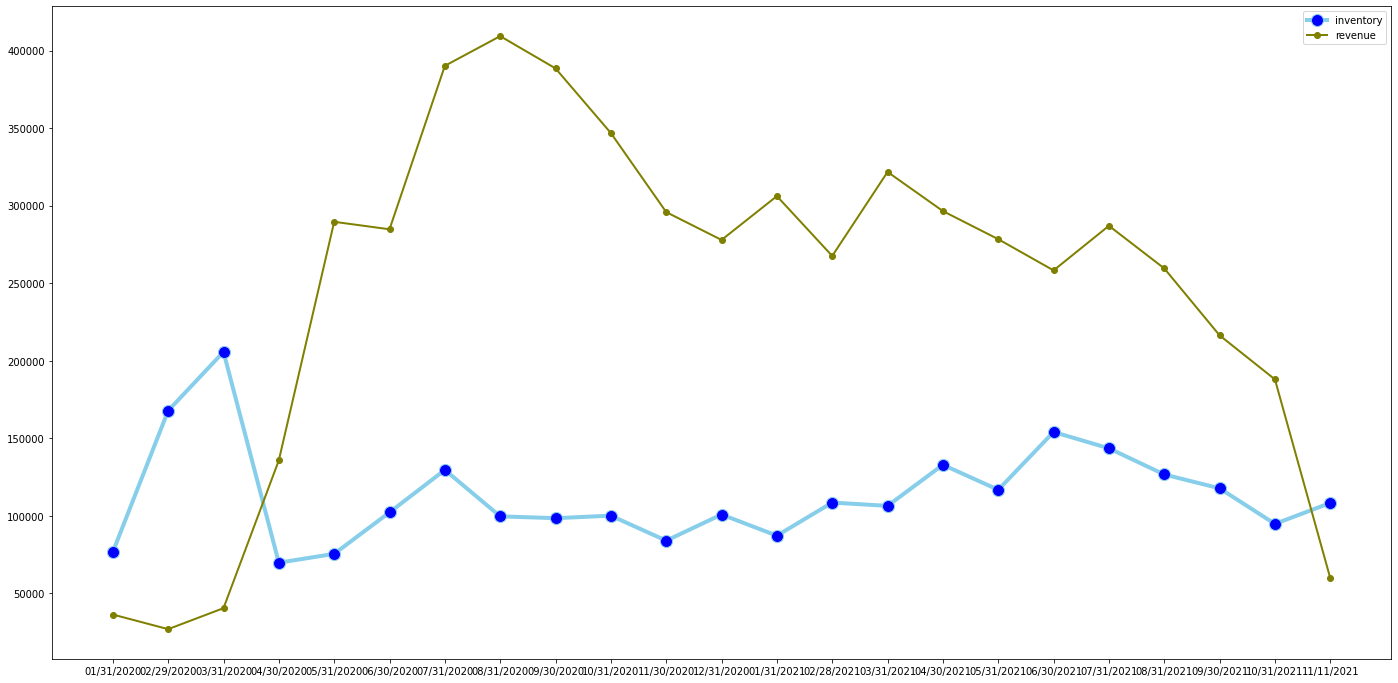

In [16]:
print(f'Plotting sales revenue vs cost-based inventory valuation for dates: {unique_inventory_dates}')
valuations_util.plot_inventory_and_revenue(
    q=q,
    sales_receipts_dataframe=d.sales_receipts_dataframe,
    inventory_valuations=inventory_valuations,
)

In [17]:
receipts_dataframe = d.sales_receipts_dataframe.copy()
fn = lambda row: f'{row.sales_datetime.year}-{"0" if row.sales_datetime.month < 10 else ""}{row.sales_datetime.month}'
col = receipts_dataframe.apply(fn, axis=1)
receipts_dataframe = receipts_dataframe.assign(sales_month=col.values)
sales_gmvs = receipts_dataframe.groupby(['sales_month'])['total_price'].sum()

In [18]:
len(sales_gmvs), len(inventory_valuations)

(23, 23)

In [21]:
output_dataframe = pandas.DataFrame(sales_gmvs)
output_dataframe['inventory_date'] = INVENTORY_DATES
output_dataframe['inventory'] = inventory_valuations
# output_dataframe = sales_gmvs.reset_index()[['sales_month', 'inventory_date', 'inventory', 'total_price']]
#output_dataframe = output_dataframe.rename(columns={'total_price': 'revenue'})
output_dataframe

,total_price,inventory_date,inventory
sales_month,,,
2020-01,36410.51,01/31/2020,76717.908772
2020-02,26991.81,02/29/2020,167853.216678
2020-03,40527.81,03/31/2020,205729.340265
2020-04,135854.75,04/30/2020,69830.159967
2020-05,289611.30,05/31/2020,75533.761915
2020-06,284792.61,06/30/2020,102274.380902
2020-07,390183.92,07/31/2020,129644.690421
2020-08,409322.19,08/31/2020,99713.999786
2020-09,388513.39,09/30/2020,98541.250000


In [ ]:
output_dataframe

In [ ]:
is_export_enabled = True

In [ ]:
import time
from datetime import date

TODAY_DATE = date.today().strftime('%m-%d-%Y')
NOW = int(time.time())

date_columns = output_dataframe.select_dtypes(include=['datetime64[ns, UTC]']).columns
for date_column in date_columns:
    output_dataframe[date_column] = output_dataframe[date_column].dt.date

#output_xlsx_file_name = f'~/Downloads/{COMPANY_IDENTIFIER}_inventories_vs_sales_analysis_{SALES_TRANSACTIONS_START_DATE}_{TODAY_DATE}_{NOW}.xlsx'

if is_export_enabled:
    num_output_rows = len(output_dataframe.index)
    print(f'Exported {num_output_rows} sales transactions to files...')
    output_dataframe.reset_index().to_excel(output_xlsx_file_name)
    print(f'Exported {num_output_rows} sales transactions to files')